In [3]:
import sys
import logging
from scapy.all import *
import pandas as pd
from tabulate import tabulate
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


# Set up logging
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger(__name__)

def read_pcap(pcap_file):
    try:
        packets = rdpcap(pcap_file)
    except FileNotFoundError:
        logger.error(f"PCAP file not found: {pcap_file}")
        sys.exit(1)
    except Scapy_Exception as e:
        logger.error(f"Error reading PCAP file: {e}")
        sys.exit(1)
    return packets

def extract_packet_data(packets):
    packet_data = []

    for packet in tqdm(packets, desc="Processing packets", unit="packet"):
        if IP in packet:
            src_ip = packet[IP].src
            dst_ip = packet[IP].dst
            protocol = packet[IP].proto
            size = len(packet)
            packet_data.append({"src_ip": src_ip, "dst_ip": dst_ip, "protocol": protocol, "size": size})

    return pd.DataFrame(packet_data)

def protocol_name(number):
    protocol_dict = {1: 'ICMP', 6: 'TCP', 17: 'UDP'}
    return protocol_dict.get(number, f"Unknown({number})")



def analyze_packet_data(df):
    total_bandwidth = df["size"].sum()
    protocol_counts = df["protocol"].value_counts(normalize=True) * 100
    protocol_counts.index = protocol_counts.index.map(protocol_name)

    ip_communication = df.groupby(["src_ip", "dst_ip"]).size().sort_values(ascending=False)
    ip_communication_percentage = ip_communication / ip_communication.sum() * 100
    ip_communication_table = pd.concat([ip_communication, ip_communication_percentage], axis=1).reset_index()

    protocol_frequency = df["protocol"].value_counts()
    protocol_frequency.index = protocol_frequency.index.map(protocol_name)

    protocol_counts_df = pd.concat([protocol_frequency, protocol_counts], axis=1).reset_index()
    protocol_counts_df.columns = ["Protocol", "Count", "Percentage"]

    ip_communication_protocols = df.groupby(["src_ip", "dst_ip", "protocol"]).size().reset_index()
    ip_communication_protocols.columns = ["Source IP", "Destination IP", "Protocol", "Count"]
    ip_communication_protocols["Protocol"] = ip_communication_protocols["Protocol"].apply(protocol_name)


    ip_communication_protocols["Percentage"] = ip_communication_protocols.groupby(["Source IP", "Destination IP"])["Count"].apply(lambda x: x / x.sum() * 100)

    return total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols

def extract_packet_data_security(packets):
    packet_data = []

    for packet in tqdm(packets, desc="Processing packets for port scanning activity", unit="packet"):
        if IP in packet:
            src_ip = packet[IP].src
            dst_ip = packet[IP].dst
            protocol = packet[IP].proto
            size = len(packet)

            if TCP in packet:
                dst_port = packet[TCP].dport
            else:
                dst_port = 0

            packet_data.append({"src_ip": src_ip, "dst_ip": dst_ip, "protocol": protocol, "size": size, "dst_port": dst_port})

    return pd.DataFrame(packet_data)

def detect_port_scanning(df,port_scan_threshold):
    # Group packets by source IP and destination port
    port_scan_df = df.groupby(['src_ip', 'dst_port']).size().reset_index(name='count')
    
    # Count the unique ports for each source IP
    unique_ports_per_ip = port_scan_df.groupby('src_ip').size().reset_index(name='unique_ports')
    
    # Check for a large number of packets to different ports on a single IP address
    potential_port_scanners = unique_ports_per_ip[unique_ports_per_ip['unique_ports'] >= port_scan_threshold]
    ip_addresses = potential_port_scanners['src_ip'].unique()
    
    if len(ip_addresses) > 0:
        logger.warning(f"Potential port scanning detected from IP addresses: {', '.join(ip_addresses)}")


def print_results(total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols):
    # Convert bandwidth to Mbps or Gbps
    if total_bandwidth < 10**9:
        bandwidth_unit = "Mbps"
        total_bandwidth /= 10**6
    else:
        bandwidth_unit = "Gbps"
        total_bandwidth /= 10**9

    logger.info(f"Total bandwidth used: {total_bandwidth:.2f} {bandwidth_unit}")
    logger.info("\nProtocol Distribution:\n")
    logger.info(tabulate(protocol_counts_df, headers=["Protocol", "Count", "Percentage"], tablefmt="grid"))
    logger.info("\nTop IP Address Communications:\n")
    logger.info(tabulate(ip_communication_table, headers=["Source IP", "Destination IP", "Count", "Percentage"], tablefmt="grid", floatfmt=".2f"))

    logger.info("\nShare of each protocol between IPs:\n")
    logger.info(tabulate(ip_communication_protocols, headers=["Source IP", "Destination IP", "Protocol", "Count", "Percentage"], tablefmt="grid", floatfmt=".2f"))

def plot_all_graphs(protocol_counts, ip_communication_protocols):
    plot_protocol_distribution(protocol_counts)
    plot_share_of_protocols_between_ips(ip_communication_protocols)


def main(pcap_file,port_scan_threshold):
    packets = read_pcap(pcap_file)
    df = extract_packet_data(packets)
    total_bandwidth, protocol_counts, ip_communication_table, protocol_frequency, ip_communication_protocols = analyze_packet_data(df)
    #latency_df = calculate_latency(packets)
    print_results(total_bandwidth, protocol_counts, ip_communication_table, protocol_frequency, ip_communication_protocols)
    df = extract_packet_data_security(packets)
    
    detect_port_scanning(df,port_scan_threshold)


if __name__ == "__main__":
    if len(sys.argv) < 2:
        logger.error("Please provide the path to the PCAP file.")
        sys.exit(1)
    
    pcap_file = sys.argv[1]
    
    # Set a default port_scan_threshold value
    default_port_scan_threshold = 100

    # Check if the port_scan_threshold argument is provided
    if len(sys.argv) >= 3:
        try:
            port_scan_threshold = int(sys.argv[2])
        except ValueError:
            logger.error("Invalid port_scan_threshold value. Using the default value.")
            port_scan_threshold = default_port_scan_threshold
    else:
        port_scan_threshold = default_port_scan_threshold
    
    main(pcap_file, port_scan_threshold)

Invalid port_scan_threshold value. Using the default value.
PCAP file not found: -f


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [1]:
import logging
import pandas as pd
from tabulate import tabulate
from scapy.all import sniff, IP, TCP, UDP
from tqdm import tqdm

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger(__name__)

def capture_live_packets(packet_count=100):
    """Capture live packets from the network interface."""
    packets = sniff(count=packet_count)
    packet_data = []

    for packet in tqdm(packets, desc="Processing packets", unit="packet"):
        if IP in packet:
            src_ip = packet[IP].src
            dst_ip = packet[IP].dst
            protocol = packet[IP].proto
            size = len(packet)

            # Check for the TCP protocol and extract destination port if available
            if TCP in packet:
                dst_port = packet[TCP].dport
            elif UDP in packet:
                dst_port = packet[UDP].dport
            else:
                dst_port = None

            packet_data.append({"src_ip": src_ip, "dst_ip": dst_ip, "protocol": protocol, "size": size, "dst_port": dst_port})

    return pd.DataFrame(packet_data)

def protocol_name(number):
    protocol_dict = {1: 'ICMP', 6: 'TCP', 17: 'UDP'}
    return protocol_dict.get(number, f"Unknown({number})")

def analyze_packet_data(df):
    total_bandwidth = df["size"].sum()
    protocol_counts = df["protocol"].value_counts(normalize=True) * 100
    protocol_counts.index = protocol_counts.index.map(protocol_name)

    ip_communication = df.groupby(["src_ip", "dst_ip"]).size().sort_values(ascending=False)
    ip_communication_percentage = ip_communication / ip_communication.sum() * 100
    ip_communication_table = pd.concat([ip_communication, ip_communication_percentage], axis=1).reset_index()

    protocol_frequency = df["protocol"].value_counts()
    protocol_frequency.index = protocol_frequency.index.map(protocol_name)

    protocol_counts_df = pd.concat([protocol_frequency, protocol_counts], axis=1).reset_index()
    protocol_counts_df.columns = ["Protocol", "Count", "Percentage"]

    ip_communication_protocols = df.groupby(["src_ip", "dst_ip", "protocol"]).size().reset_index()
    ip_communication_protocols.columns = ["Source IP", "Destination IP", "Protocol", "Count"]
    ip_communication_protocols["Protocol"] = ip_communication_protocols["Protocol"].apply(protocol_name)
    ip_communication_protocols["Percentage"] = ip_communication_protocols.groupby(["Source IP", "Destination IP"])["Count"].apply(lambda x: x / x.sum() * 100)

    return total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols

def detect_port_scanning(df, port_scan_threshold):
    port_scan_df = df.groupby(['src_ip', 'dst_port']).size().reset_index(name='count')
    unique_ports_per_ip = port_scan_df.groupby('src_ip').size().reset_index(name='unique_ports')
    potential_port_scanners = unique_ports_per_ip[unique_ports_per_ip['unique_ports'] >= port_scan_threshold]
    ip_addresses = potential_port_scanners['src_ip'].unique()

    if len(ip_addresses) > 0:
        logger.warning(f"Potential port scanning detected from IP addresses: {', '.join(ip_addresses)}")

def print_results(total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols):
    bandwidth_unit = "Mbps" if total_bandwidth < 10**9 else "Gbps"
    total_bandwidth /= 10**6 if bandwidth_unit == "Mbps" else 10**9
    logger.info(f"Total bandwidth used: {total_bandwidth:.2f} {bandwidth_unit}")
    logger.info("\nProtocol Distribution:\n")
    logger.info(tabulate(protocol_counts_df, headers=["Protocol", "Count", "Percentage"], tablefmt="grid"))
    logger.info("\nTop IP Address Communications:\n")
    logger.info(tabulate(ip_communication_table, headers=["Source IP", "Destination IP", "Count", "Percentage"], tablefmt="grid", floatfmt=".2f"))
    logger.info("\nShare of each protocol between IPs:\n")
    logger.info(tabulate(ip_communication_protocols, headers=["Source IP", "Destination IP", "Protocol", "Count", "Percentage"], tablefmt="grid", floatfmt=".2f"))

def main(packet_count=100, port_scan_threshold=100):
    df = capture_live_packets(packet_count)
    total_bandwidth, protocol_counts, ip_communication_table, protocol_frequency, ip_communication_protocols = analyze_packet_data(df)
    print_results(total_bandwidth, protocol_counts, ip_communication_table, protocol_frequency, ip_communication_protocols)
    detect_port_scanning(df, port_scan_threshold)

# Set the number of packets to capture and the port scan threshold
main(packet_count=50, port_scan_threshold=5)

Processing packets: 100%|████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 9670.98packet/s]


TypeError: incompatible index of inserted column with frame index

In [2]:
import pandas as pd
from scapy.all import sniff
from tqdm import tqdm

# Define the protocol names for the IP protocols
def protocol_name(protocol_number):
    protocol_map = {
        1: "ICMP",
        6: "TCP",
        17: "UDP",
        47: "GRE",
        51: "ESP",
        58: "ICMPv6",
        89: "OSPF",
        132: "SCTP",
        143: "IMAP",
        245: "ISAKMP"
    }
    return protocol_map.get(protocol_number, str(protocol_number))

# Function to capture live packets from the network interface
def capture_live_packets(packet_count=100):
    """Capture live packets from the network interface."""
    packets = sniff(count=packet_count)
    packet_data = []

    for packet in tqdm(packets, desc="Processing packets", unit="packet"):
        try:
            timestamp = packet.time
            src_ip = packet[1].src
            dst_ip = packet[1].dst
            protocol = packet[1].proto
            size = len(packet)
            packet_data.append([timestamp, src_ip, dst_ip, protocol, size])
        except IndexError:
            continue

    df = pd.DataFrame(packet_data, columns=["Timestamp", "src_ip", "dst_ip", "protocol", "size"])
    return df

# Function to analyze packet data
def analyze_packet_data(df):
    total_bandwidth = df["size"].sum()
    protocol_counts = df["protocol"].value_counts(normalize=True) * 100
    protocol_counts.index = protocol_counts.index.map(protocol_name)

    ip_communication = df.groupby(["src_ip", "dst_ip"]).size().sort_values(ascending=False)
    ip_communication_percentage = ip_communication / ip_communication.sum() * 100
    ip_communication_table = pd.concat([ip_communication, ip_communication_percentage], axis=1).reset_index()

    protocol_frequency = df["protocol"].value_counts()
    protocol_frequency.index = protocol_frequency.index.map(protocol_name)

    protocol_counts_df = pd.concat([protocol_frequency, protocol_counts], axis=1).reset_index()
    protocol_counts_df.columns = ["Protocol", "Count", "Percentage"]

    ip_communication_protocols = df.groupby(["src_ip", "dst_ip", "protocol"]).size().reset_index()
    ip_communication_protocols.columns = ["Source IP", "Destination IP", "Protocol", "Count"]
    ip_communication_protocols["Protocol"] = ip_communication_protocols["Protocol"].apply(protocol_name)

    # Fix: reset index after calculating percentage
    ip_communication_protocols["Percentage"] = ip_communication_protocols.groupby(["Source IP", "Destination IP"])["Count"].apply(lambda x: x / x.sum() * 100).values

    return total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols

# Function to print the analysis results
def print_results(total_bandwidth, protocol_counts, ip_communication_table, protocol_frequency, ip_communication_protocols):
    print(f"Total Bandwidth: {total_bandwidth} bytes")
    print("\nProtocol Distribution:")
    print(protocol_counts)

    print("\nIP Communication Table (Top 10):")
    print(ip_communication_table.head(10))

    print("\nProtocol Frequency:")
    print(protocol_frequency)

    print("\nIP Communication Protocols:")
    print(ip_communication_protocols.head(10))

# Function to detect port scanning activities
def detect_port_scanning(df, port_scan_threshold=100):
    ip_count = df.groupby("src_ip")["dst_ip"].nunique()
    suspicious_ips = ip_count[ip_count >= port_scan_threshold]
    
    if not suspicious_ips.empty:
        print("\nSuspicious IPs (Port Scanning Detected):")
        print(suspicious_ips)
    else:
        print("\nNo port scanning activities detected.")

# Main function to capture and analyze network traffic
def main(packet_count=50, port_scan_threshold=5):
    df = capture_live_packets(packet_count)
    total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols = analyze_packet_data(df)
    print_results(total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols)
    detect_port_scanning(df, port_scan_threshold)

# Set the number of packets to capture and the port scan threshold
main(packet_count=50, port_scan_threshold=5)


Processing packets:  30%|███████████████████▊                                              | 15/50 [00:00<?, ?packet/s]


AttributeError: src

In [3]:
import pandas as pd
from scapy.all import sniff
from tqdm import tqdm

# Define the protocol names for the IP protocols
def protocol_name(protocol_number):
    protocol_map = {
        1: "ICMP",
        6: "TCP",
        17: "UDP",
        47: "GRE",
        51: "ESP",
        58: "ICMPv6",
        89: "OSPF",
        132: "SCTP",
        143: "IMAP",
        245: "ISAKMP"
    }
    return protocol_map.get(protocol_number, str(protocol_number))

# Function to capture live packets from the network interface
def capture_live_packets(packet_count=100):
    """Capture live packets from the network interface."""
    packets = sniff(count=packet_count)
    packet_data = []

    for packet in tqdm(packets, desc="Processing packets", unit="packet"):
        try:
            if packet.haslayer("IP"):  # Only process packets with an IP layer
                timestamp = packet.time
                src_ip = packet["IP"].src
                dst_ip = packet["IP"].dst
                protocol = packet["IP"].proto
                size = len(packet)
                packet_data.append([timestamp, src_ip, dst_ip, protocol, size])
        except IndexError:
            continue

    df = pd.DataFrame(packet_data, columns=["Timestamp", "src_ip", "dst_ip", "protocol", "size"])
    return df

# Function to analyze packet data
def analyze_packet_data(df):
    total_bandwidth = df["size"].sum()
    protocol_counts = df["protocol"].value_counts(normalize=True) * 100
    protocol_counts.index = protocol_counts.index.map(protocol_name)

    ip_communication = df.groupby(["src_ip", "dst_ip"]).size().sort_values(ascending=False)
    ip_communication_percentage = ip_communication / ip_communication.sum() * 100
    ip_communication_table = pd.concat([ip_communication, ip_communication_percentage], axis=1).reset_index()

    protocol_frequency = df["protocol"].value_counts()
    protocol_frequency.index = protocol_frequency.index.map(protocol_name)

    protocol_counts_df = pd.concat([protocol_frequency, protocol_counts], axis=1).reset_index()
    protocol_counts_df.columns = ["Protocol", "Count", "Percentage"]

    ip_communication_protocols = df.groupby(["src_ip", "dst_ip", "protocol"]).size().reset_index()
    ip_communication_protocols.columns = ["Source IP", "Destination IP", "Protocol", "Count"]
    ip_communication_protocols["Protocol"] = ip_communication_protocols["Protocol"].apply(protocol_name)

    # Fix: reset index after calculating percentage
    ip_communication_protocols["Percentage"] = ip_communication_protocols.groupby(["Source IP", "Destination IP"])["Count"].apply(lambda x: x / x.sum() * 100).values

    return total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols

# Function to print the analysis results
def print_results(total_bandwidth, protocol_counts, ip_communication_table, protocol_frequency, ip_communication_protocols):
    print(f"Total Bandwidth: {total_bandwidth} bytes")
    print("\nProtocol Distribution:")
    print(protocol_counts)

    print("\nIP Communication Table (Top 10):")
    print(ip_communication_table.head(10))

    print("\nProtocol Frequency:")
    print(protocol_frequency)

    print("\nIP Communication Protocols:")
    print(ip_communication_protocols.head(10))

# Function to detect port scanning activities
def detect_port_scanning(df, port_scan_threshold=100):
    ip_count = df.groupby("src_ip")["dst_ip"].nunique()
    suspicious_ips = ip_count[ip_count >= port_scan_threshold]
    
    if not suspicious_ips.empty:
        print("\nSuspicious IPs (Port Scanning Detected):")
        print(suspicious_ips)
    else:
        print("\nNo port scanning activities detected.")

# Main function to capture and analyze network traffic
def main(packet_count=50, port_scan_threshold=5):
    df = capture_live_packets(packet_count)
    total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols = analyze_packet_data(df)
    print_results(total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols)
    detect_port_scanning(df, port_scan_threshold)

# Set the number of packets to capture and the port scan threshold
main(packet_count=50, port_scan_threshold=5)


Processing packets: 100%|██████████████████████████████████████████████████████████████████| 50/50 [00:00<?, ?packet/s]


Total Bandwidth: 14071 bytes

Protocol Distribution:
  Protocol  Count  Percentage
0      TCP     39       81.25
1      UDP      9       18.75

IP Communication Table (Top 10):
            src_ip           dst_ip   0          1
0  192.168.108.214      20.42.73.25  15  31.250000
1      20.42.73.25  192.168.108.214  11  22.916667
2  192.168.108.214  192.168.108.185   6  12.500000
3   142.250.182.42  192.168.108.214   4   8.333333
4  192.168.108.185  192.168.108.214   3   6.250000
5    140.82.114.25  192.168.108.214   2   4.166667
6  192.168.108.214   142.250.182.42   2   4.166667
7  192.168.108.214    140.82.114.25   1   2.083333
8  192.168.108.214    20.187.186.89   1   2.083333
9  192.168.108.214   52.182.143.209   1   2.083333

Protocol Frequency:
protocol
TCP    39
UDP     9
Name: count, dtype: int64

IP Communication Protocols:
         Source IP   Destination IP Protocol  Count  Percentage
0    140.82.114.25  192.168.108.214      TCP      2  100.000000
1   142.250.182.42  192.168.1

Processing packets: 100%|███████████████████████████████████████████████████████| 50/50 [00:00<00:00, 25112.59packet/s]



Total Bandwidth: 18974 bytes

Protocol Distribution (Percentage of Total Traffic):
  Protocol  Count  Percentage
0      UDP     32   66.666667
1      TCP     16   33.333333

IP Communication Table (Top 10 Most Frequent Communications):
            src_ip           dst_ip   0          1
0  192.168.108.214   216.58.196.174  15  31.250000
1   216.58.196.174  192.168.108.214  14  29.166667
2  192.168.108.214  192.168.108.185   8  16.666667
3  192.168.108.185  192.168.108.214   4   8.333333
4     13.107.42.16  192.168.108.214   2   4.166667
5   142.250.182.42  192.168.108.214   2   4.166667
6  192.168.108.214     13.107.42.16   2   4.166667
7  192.168.108.214   142.250.182.42   1   2.083333

Protocol Frequency (Count of Packets per Protocol):
protocol
UDP    32
TCP    16
Name: count, dtype: int64

IP Communication Protocols (Protocols used in IP Communications):
         Source IP   Destination IP Protocol  Count  Percentage
0     13.107.42.16  192.168.108.214      TCP      2       100.0
1

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\ASUS\AppData\Local\Temp\ipykernel_18216\405321292.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=protocol_counts.index, y=protocol_counts.values, palette="Blues_d")
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


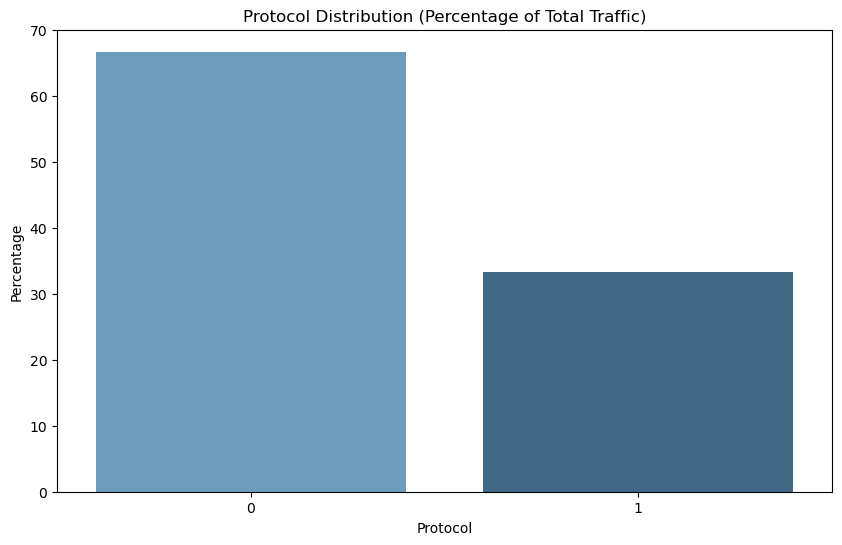

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18216\405321292.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10["src_ip"] + " -> " + top_10["dst_ip"], y=top_10[0], palette="viridis")


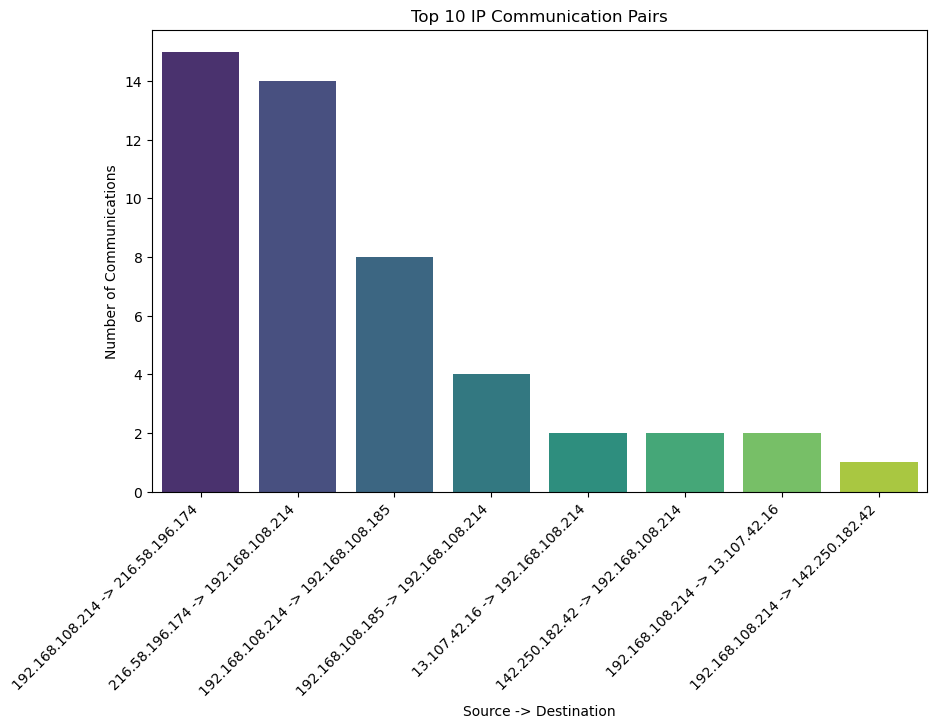

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scapy.all import sniff
from tqdm import tqdm

# Define the protocol names for the IP protocols
def protocol_name(protocol_number):
    protocol_map = {
        1: "ICMP",
        6: "TCP",
        17: "UDP",
        47: "GRE",
        51: "ESP",
        58: "ICMPv6",
        89: "OSPF",
        132: "SCTP",
        143: "IMAP",
        245: "ISAKMP"
    }
    return protocol_map.get(protocol_number, str(protocol_number))

# Function to capture live packets from the network interface
def capture_live_packets(packet_count=100):
    """Capture live packets from the network interface."""
    packets = sniff(count=packet_count)
    packet_data = []

    for packet in tqdm(packets, desc="Processing packets", unit="packet"):
        try:
            if packet.haslayer("IP"):  # Only process packets with an IP layer
                timestamp = packet.time
                src_ip = packet["IP"].src
                dst_ip = packet["IP"].dst
                protocol = packet["IP"].proto
                size = len(packet)
                packet_data.append([timestamp, src_ip, dst_ip, protocol, size])
        except IndexError:
            continue

    df = pd.DataFrame(packet_data, columns=["Timestamp", "src_ip", "dst_ip", "protocol", "size"])
    return df

# Function to analyze packet data
def analyze_packet_data(df):
    total_bandwidth = df["size"].sum()
    protocol_counts = df["protocol"].value_counts(normalize=True) * 100
    protocol_counts.index = protocol_counts.index.map(protocol_name)

    ip_communication = df.groupby(["src_ip", "dst_ip"]).size().sort_values(ascending=False)
    ip_communication_percentage = ip_communication / ip_communication.sum() * 100
    ip_communication_table = pd.concat([ip_communication, ip_communication_percentage], axis=1).reset_index()

    protocol_frequency = df["protocol"].value_counts()
    protocol_frequency.index = protocol_frequency.index.map(protocol_name)

    protocol_counts_df = pd.concat([protocol_frequency, protocol_counts], axis=1).reset_index()
    protocol_counts_df.columns = ["Protocol", "Count", "Percentage"]

    ip_communication_protocols = df.groupby(["src_ip", "dst_ip", "protocol"]).size().reset_index()
    ip_communication_protocols.columns = ["Source IP", "Destination IP", "Protocol", "Count"]
    ip_communication_protocols["Protocol"] = ip_communication_protocols["Protocol"].apply(protocol_name)

    # Fix: reset index after calculating percentage
    ip_communication_protocols["Percentage"] = ip_communication_protocols.groupby(["Source IP", "Destination IP"])["Count"].apply(lambda x: x / x.sum() * 100).values

    return total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols

# Function to print the analysis results in a more structured format
def print_results(total_bandwidth, protocol_counts, ip_communication_table, protocol_frequency, ip_communication_protocols):
    print("\n" + "="*50)
    print(f"Total Bandwidth: {total_bandwidth} bytes")
    print("="*50)
    
    print("\nProtocol Distribution (Percentage of Total Traffic):")
    print(protocol_counts)
    print("="*50)

    print("\nIP Communication Table (Top 10 Most Frequent Communications):")
    print(ip_communication_table.head(10))
    print("="*50)

    print("\nProtocol Frequency (Count of Packets per Protocol):")
    print(protocol_frequency)
    print("="*50)

    print("\nIP Communication Protocols (Protocols used in IP Communications):")
    print(ip_communication_protocols.head(10))
    print("="*50)

# Function to detect port scanning activities
def detect_port_scanning(df, port_scan_threshold=100):
    ip_count = df.groupby("src_ip")["dst_ip"].nunique()
    suspicious_ips = ip_count[ip_count >= port_scan_threshold]
    
    if not suspicious_ips.empty:
        print("\nSuspicious IPs (Port Scanning Detected):")
        print(suspicious_ips)
    else:
        print("\nNo port scanning activities detected.")
    print("="*50)

# Plot the protocol distribution
def plot_protocol_distribution(protocol_counts):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=protocol_counts.index, y=protocol_counts.values, palette="Blues_d")
    plt.title("Protocol Distribution (Percentage of Total Traffic)")
    plt.xlabel("Protocol")
    plt.ylabel("Percentage")
    plt.show()

# Plot the IP Communication Table (Top 10 IP communications)
def plot_ip_communication(ip_communication_table):
    top_10 = ip_communication_table.head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_10["src_ip"] + " -> " + top_10["dst_ip"], y=top_10[0], palette="viridis")
    plt.title("Top 10 IP Communication Pairs")
    plt.xlabel("Source -> Destination")
    plt.ylabel("Number of Communications")
    plt.xticks(rotation=45, ha="right")
    plt.show()

# Main function to capture and analyze network traffic
def main(packet_count=50, port_scan_threshold=5):
    df = capture_live_packets(packet_count)
    total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols = analyze_packet_data(df)
    print_results(total_bandwidth, protocol_counts_df, ip_communication_table, protocol_frequency, ip_communication_protocols)
    detect_port_scanning(df, port_scan_threshold)
    
    # Plot the results for better visualization
    plot_protocol_distribution(protocol_counts_df["Percentage"])
    plot_ip_communication(ip_communication_table)

# Set the number of packets to capture and the port scan threshold
main(packet_count=50, port_scan_threshold=5)
